In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

import pandas as pd
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sn
import pathlib
import matplotlib.pyplot as plt

In [20]:
cwd = os.getcwd()
data_dir = cwd+"/archive/train"
data_dir = pathlib.Path(data_dir)

test_data_dir = cwd+"/archive/test"
test_data_dir = pathlib.Path(test_data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(str(image_count))


31226


In [23]:
epochs=26

batch_size = 32
img_height = 100
img_width = 100

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=(img_height, img_width),
    batch_size=batch_size)


test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',
    label_mode='int',
    shuffle=False,
    color_mode="grayscale",
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 31226 files belonging to 26 classes.
Using 24981 files for training.
Found 31226 files belonging to 26 classes.
Using 6245 files for validation.
Found 7774 files belonging to 26 classes.


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)


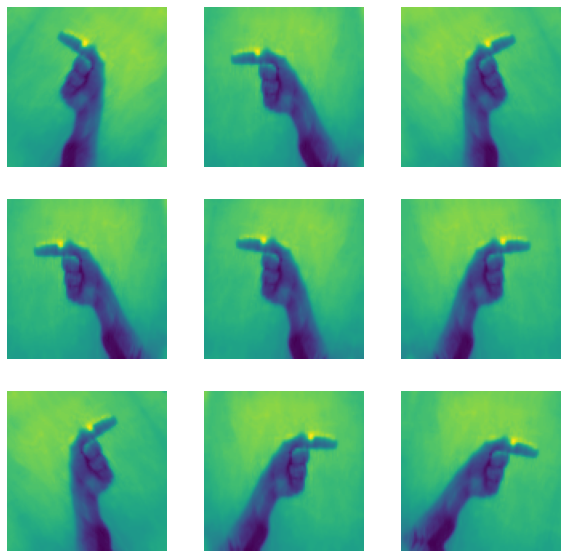

In [32]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
        input_shape=(img_height,img_width,1)),
        layers.RandomRotation(0.1)
    ]
)
callback = EarlyStopping(monitor='val_loss', patience=3)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    print(images.shape)

In [33]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 100, 100, 1)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 100, 100, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose = 1,
    callbacks=callback,
    epochs=epochs
)

Epoch 1/25
1561/1561 [==============================] - 785s 473ms/step - loss: 2.0907 - accuracy: 0.3432 - val_loss: 1.0102 - val_accuracy: 0.6720
Epoch 2/25
1561/1561 [==============================] - 647s 415ms/step - loss: 0.9873 - accuracy: 0.6676 - val_loss: 0.6944 - val_accuracy: 0.7476
Epoch 3/25
1561/1561 [==============================] - 614s 393ms/step - loss: 0.6587 - accuracy: 0.7731 - val_loss: 0.3718 - val_accuracy: 0.8698
Epoch 4/25
1561/1561 [==============================] - 569s 365ms/step - loss: 0.4971 - accuracy: 0.8269 - val_loss: 0.2582 - val_accuracy: 0.9082
Epoch 5/25
1561/1561 [==============================] - 524s 336ms/step - loss: 0.3930 - accuracy: 0.8627 - val_loss: 0.2235 - val_accuracy: 0.9209
Epoch 6/25
1561/1561 [==============================] - 570s 365ms/step - loss: 0.3203 - accuracy: 0.8872 - val_loss: 0.2059 - val_accuracy: 0.9217
Epoch 7/25
1561/1561 [==============================] - 524s 336ms/step - loss: 0.2819 - accuracy: 0.9020 - val_

In [13]:
name = "asl_recog_E"
name += str(epochs)
name += "-"
name += str(img_height)
name += "x"
name += str(img_width)
name += ".model"
model.save(name, save_format='h5')

In [14]:
print("--------------------------------------------------------------------------------------------------------")
model.evaluate(test_ds, verbose=1)
print("========================================================================================================")

--------------------------------------------------------------------------------------------------------
487/487 [==============================] - 95s 195ms/step - loss: 0.9356 - accuracy: 0.8058


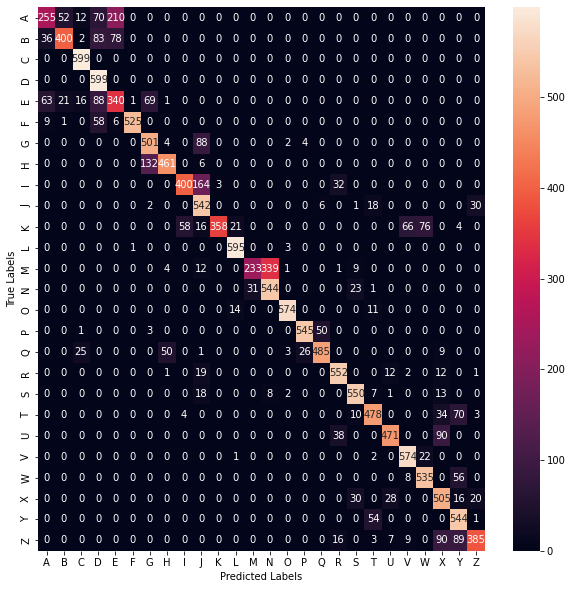

In [17]:
predictions = np.array([])
labels =  np.array([])

for x, y in test_ds:
    #print(str(x)+":"+str(y))
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, y.numpy()])



cfmx = np.array(tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy())

plt.figure(figsize = (10,10))
heatmap = sn.heatmap(cfmx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
heatmap.set(xlabel='Predicted Labels', ylabel='True Labels')
name = "ConfMatrix"
name += "-E"
name += str(epochs)
name += "-"
name += str(img_height)
name += ".jpg"
plt.savefig(name)
#plt.show()

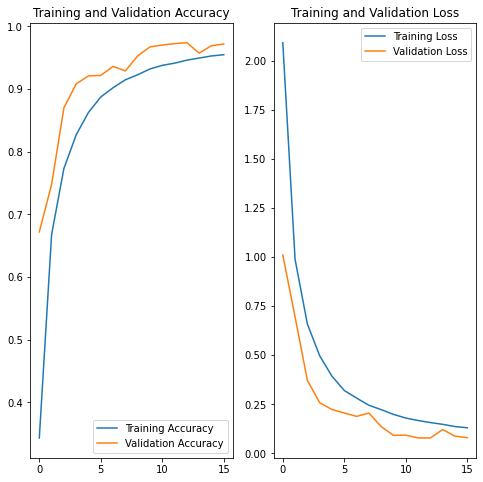

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
name = "ACCxLOSS"
name += "-E"
name += str(epochs)
name += "_"
name += str(img_height)
name += ".jpg"
plt.savefig(name)